In [2]:

from tnia.deconvolution.forward import forward
from tnia.plotting.projections import show_xyz_slice, show_xyz_max
import raster_geometry as rg
from tnia.simulation.phantoms import add_small_to_large
import numpy as np

# Create simulated image

Draw a phantom made of points and/or spheres.  The options are endless but right now options are 

1.  A point in the center
2.  A sphere of radius r in the center. 
3.  A grid of spheres of different radii and intensity centered axially in a 3D image space. 

Use gain and background to control SNR (high gain and/or background = higher SNR)

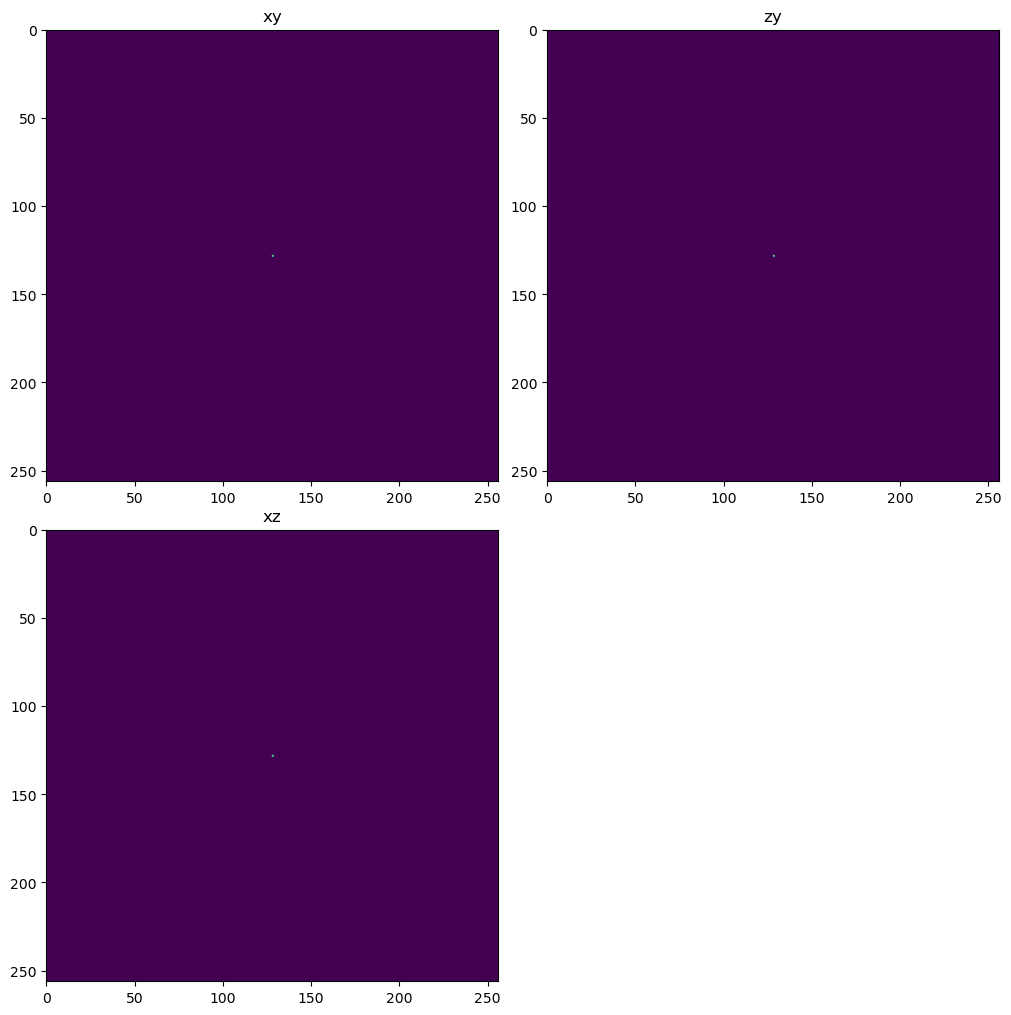

In [45]:

gain = 1000
background = 0 

zdim = 256
ydim = 256
xdim = 256

phantom = np.zeros((zdim,ydim,xdim), dtype=np.float32)

depth = zdim//2

phantom_type = 0 

if phantom_type == 0:
    gain = 100000
    phantom[zdim//2, ydim//2, xdim//2] = gain*100
    fig = show_xyz_max(phantom)
elif phantom_type == 1:
    r = 5
    size = [2*r, 2*r, 2*r]
    sphere = rg.sphere(size, r).astype(np.float32)
    add_small_to_large(phantom, gain*100*sphere, xdim//2, ydim//2, zdim//2)
    fig = show_xyz_max(phantom)
if phantom_type == 2:

    radii = [1, 2, 3, 4]
    intensities = [gain*100, gain*200, gain*300, gain*400]

    x_pos = xdim//8

    for i in intensities:
        y_pos = ydim//8
        for r in radii:
            size = [2*r, 2*r, 2*r]
            sphere = rg.sphere(size, r).astype(np.float32)
            add_small_to_large(phantom, i*sphere, x_pos, y_pos, depth)
            y_pos += ydim//4
        x_pos += xdim//4

    fig = show_xyz_max(phantom)


## Create a PSF

PSF is twice as big as image to avoid 'block' artifacts and make sure we simulate light propagating though the entire image. 

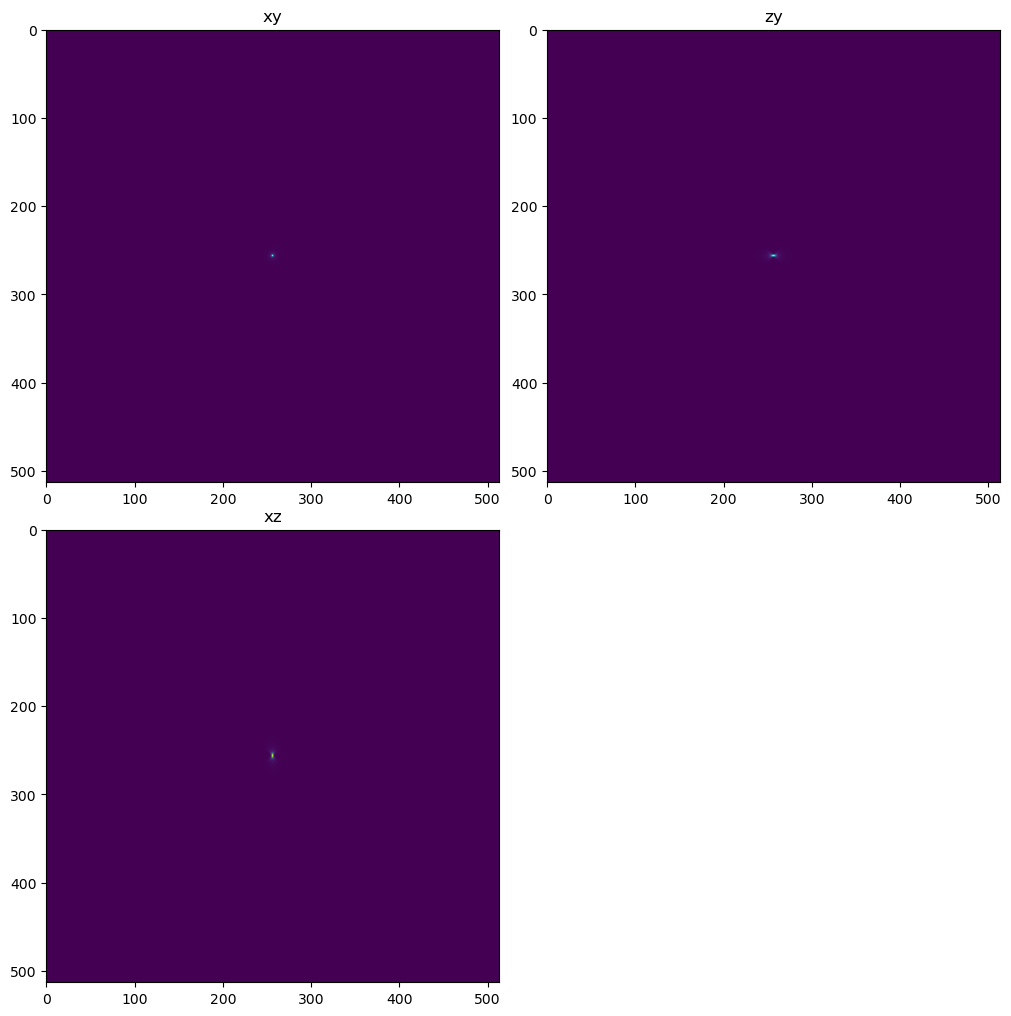

In [4]:
from tnia.deconvolution.psfs import gibson_lanni_3D

x_voxel_size = 0.1
z_voxel_size=0.1

sxy = 1
sz = z_voxel_size/x_voxel_size

xy_psf_dim=xdim*2+1
z_psf_dim=ydim*2+1

NA=1.4

# ni is the refractive index of the immersion medium of the lens
ni=1.5
# ns is the refractive index of the sample
ns=1.33

# depth at which to calculate the PSF (note if there is a RI mismatch between the lens RI and sample RI spherical aberration will be introduced
# which will be depth dependent)
depth = 0

psf  = gibson_lanni_3D(NA, ni, ns, x_voxel_size, z_voxel_size, xy_psf_dim, z_psf_dim, depth, 0.5, False, True)
psf = psf.astype('float32')
psf = psf/psf.sum()

fig = show_xyz_max(psf)

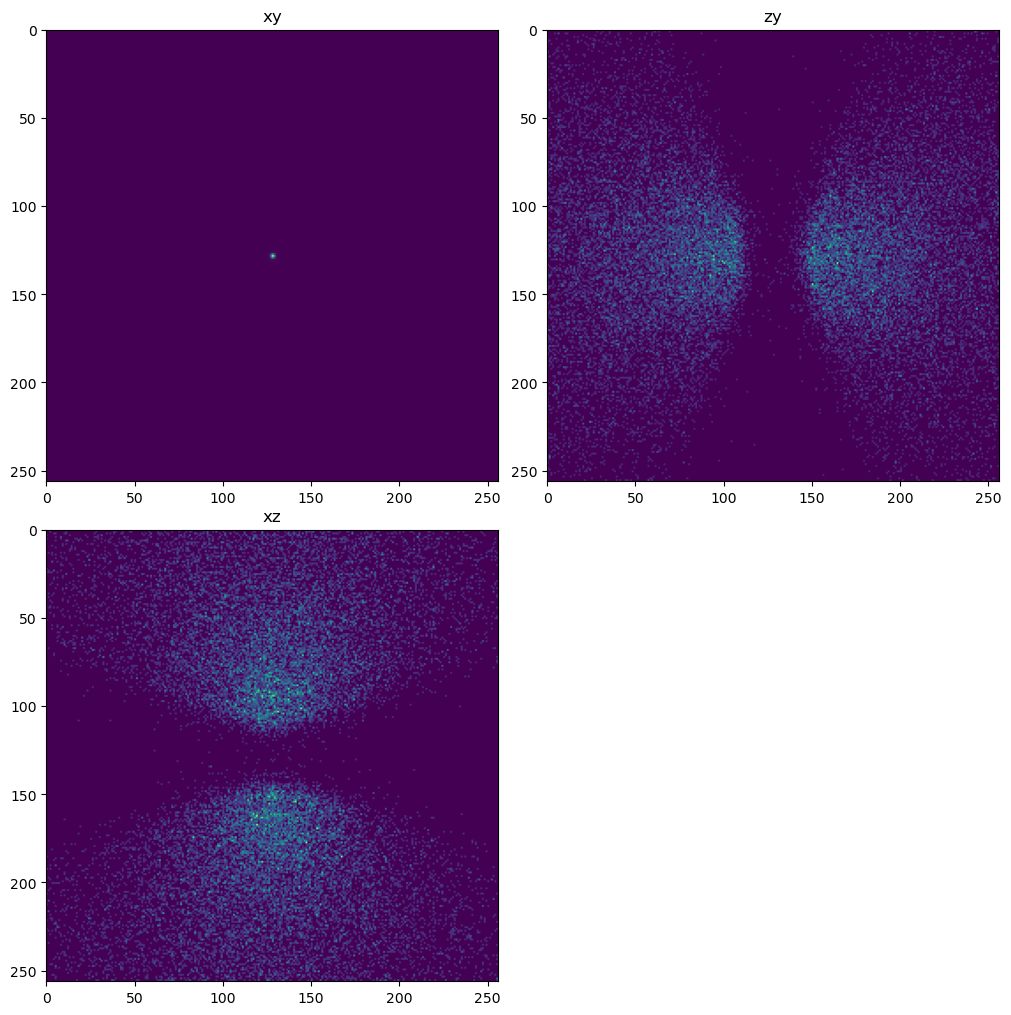

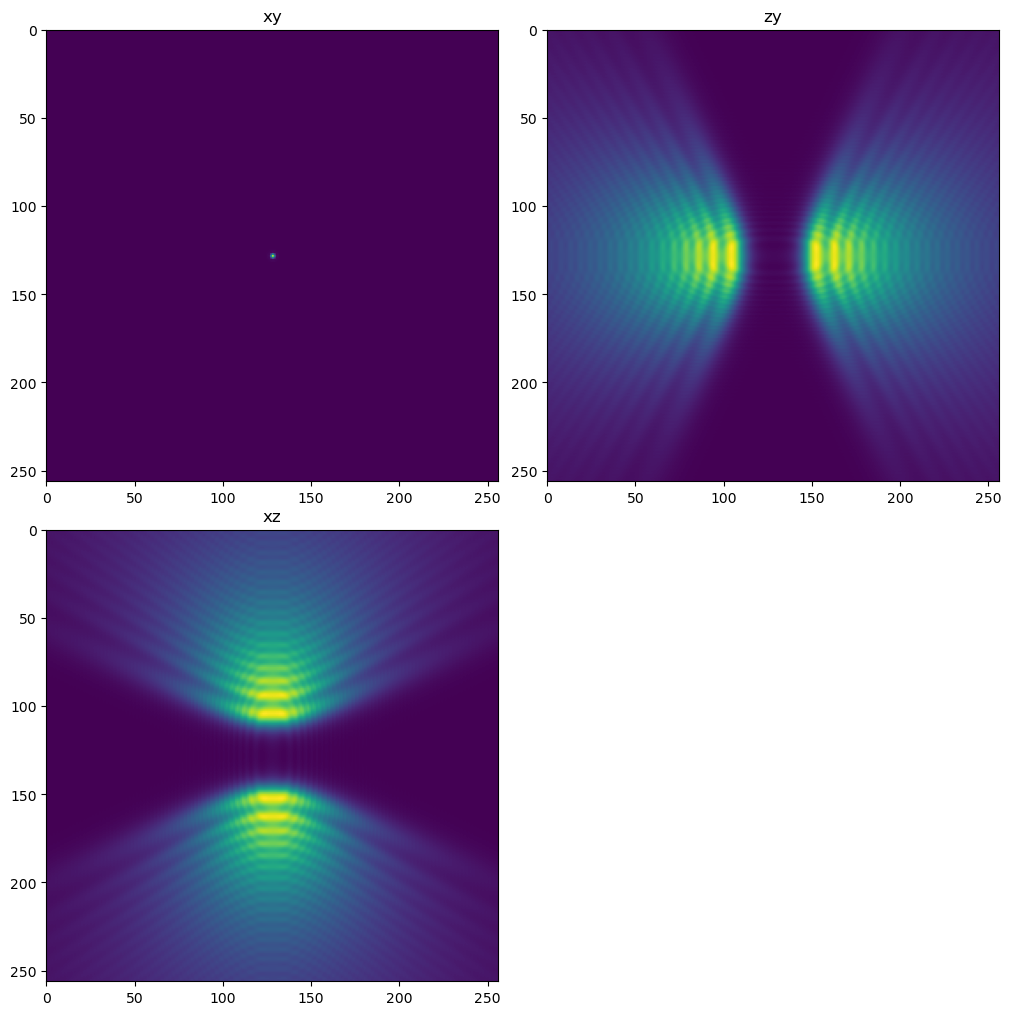

In [46]:
im = forward(phantom, psf, background, True, True)
im_noise_less = forward(phantom, psf, background, False, True)

x_v = im.shape[2]//2+im.shape[2]//8
y_v = im.shape[1]//2+im.shape[1]//8
z_v = im.shape[0]//2

phantom=phantom+background

fig = show_xyz_slice(im, x_v, y_v, z_v, sxy=sxy, sz=sz)
fig = show_xyz_slice(im_noise_less, x_v, y_v, z_v, sxy=sxy, sz=sz)

In [10]:
planes

[128, 118, 78, 28]

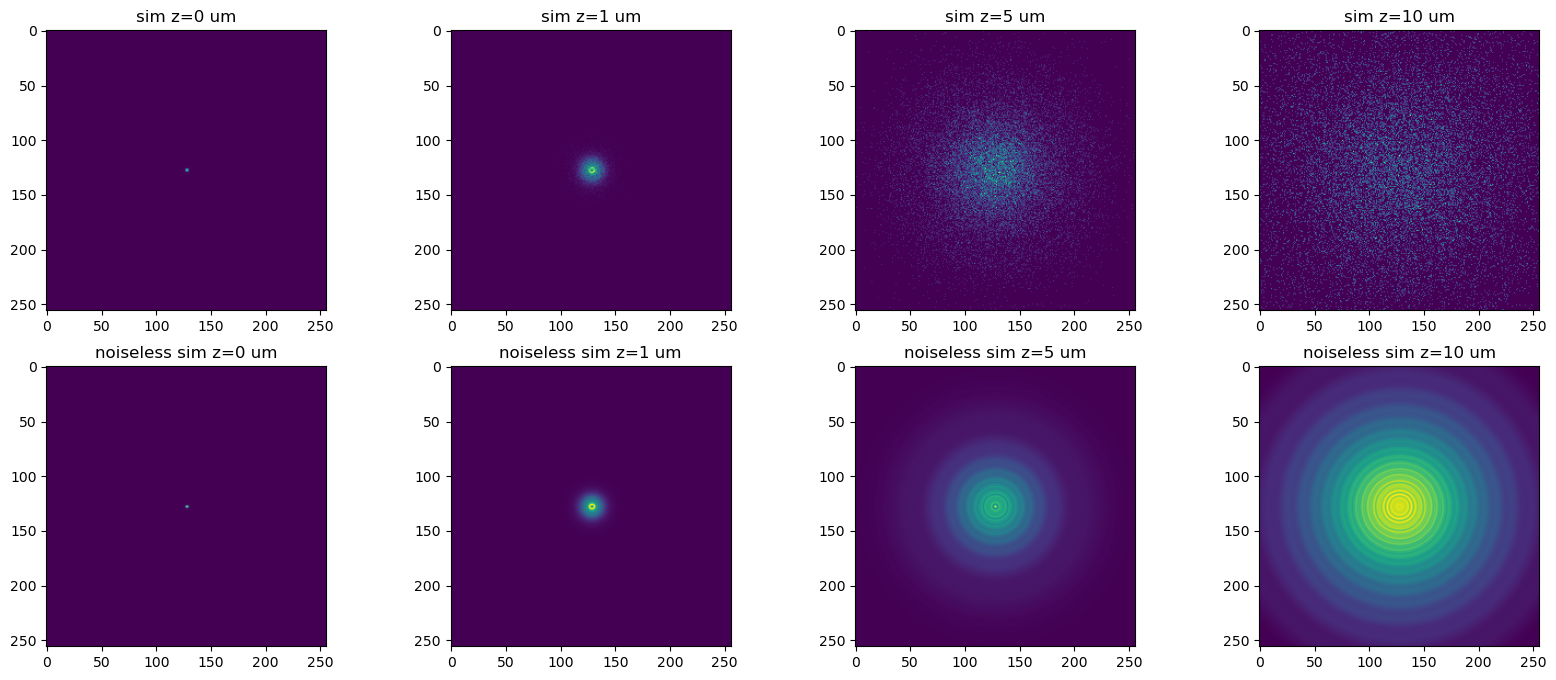

In [47]:
focuses = [0, 1, 5, 10]
focus_plane = phantom.shape[0]//2

planes = [focus_plane-int(f/z_voxel_size) for f in focuses]

ims = []
titles = []

for p,f in zip(planes,focuses):
    ims.append(im[p])
    titles.append(f'sim z={f} um') 
    
for p,f in zip(planes,focuses):
    ims.append(im_noise_less[p])
    titles.append(f'noiseless sim z={f} um')

from tnia.plotting.plt_helper import imshow_multi2d

fig = imshow_multi2d(ims, titles, 2, len(planes), 20, 8)

In [31]:
import napari

viewer = napari.Viewer()
viewer.add_image(phantom)
viewer.add_image(im)
viewer.add_image(im_noise_less)

<Image layer 'im_noise_less' at 0x28f1b90df70>

In [49]:
# save figure
fig.savefig('single_point_simulation.png')

In [50]:
690*1.5, 276*1.5

(1035.0, 414.0)